# Exploratory Data Analysis of the Waymo Open Dataset
## Object Attributes

This Jupyter Notebook explores Object Instance Data extracted from the labels of approximately 500,000 objects over 8,000 frames of the Waymo Open Dataset. 


In [255]:
import os
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import itertools
import collections
import scipy.stats as sts
import plot_functions as pf

In [35]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

Read in 'objects500k.csv'. This csv file contains nearly 500,000 objects taken from 8,000 frames of the Waymo dataset.

In [37]:
objects_df = pd.read_csv('objects500k.csv')

The objects contain location data broken down into x, y, z coordinates. Below, we calculate the distance of each object from the Waymo car in the x-y plane. 

In [641]:
objects_df['distance'] = np.sqrt(objects_df['location_x']**2 + objects_df['location_y']**2)

In [642]:
objects_df.head()

,Unnamed: 0,category,dimension_height,dimension_length,dimension_width,heading,location_x,location_y,location_z,distance
0,0,pedestrian,1.889434,1.036285,0.869548,28.046370,-21.392696,34.256657,-0.167213,40.387696
1,1,pedestrian,1.650000,0.905959,0.784573,-176.548462,10.391662,20.009092,0.140395,22.546627
2,2,pedestrian,2.000000,0.655752,0.789083,154.997238,67.121521,0.957747,1.680581,67.128354
3,3,pedestrian,2.100000,0.734008,0.863620,89.197525,28.183521,-33.817711,3.271440,44.022136
4,4,pedestrian,1.642014,0.941461,0.776469,-169.396439,-65.372452,17.677683,-0.608567,67.720439


In [ ]:
pedestrians = objects_df[objects_df['category'] == 'pedestrian'].copy()
cyclists = objects_df[objects_df['category'] == 'cyclist'].copy()
vehicles = objects_df[objects_df['category'] == 'vehicle'].copy()
signs = objects_df[objects_df['category'] == 'sign'].copy()

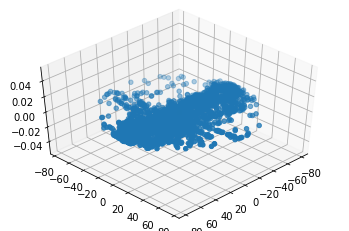

In [97]:
ax = plt.axes(projection='3d')
ax.view_init(45, 45)

zdata = np.zeros(len(cyclists['location_z']))
xdata = cyclists['location_x']
ydata = cyclists['location_y']
ax.scatter3D(xdata, ydata, zdata)

z = 0
y = 0
x = 0
ax.scatter3D(x, y, z, 'Blue', marker='o');

In [41]:
def plot_obj_pc(object_type, color='b', alpha=0.1):
	ax = plt.axes()

	xdata = object_type['location_x']
	ydata = object_type['location_y']
	ax.scatter(xdata, ydata, c=color, alpha=alpha)

	waymo_y = 0
	waymo_x = 0
	ax.scatter(waymo_x, waymo_y, c='k');

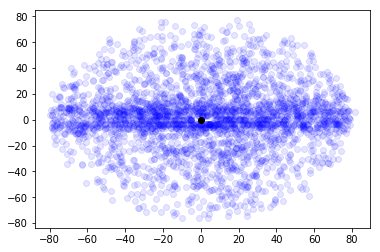

In [99]:
plot_obj_pc(vehicles.sample(3000), color='b', alpha=0.1)

In [65]:
def plot_subgroup_hist(df, sub_a, sub_b):
    '''
    Displays information of 2 sub groups of a data set 
    '''
    
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        height, binz = np.histogram(sub_a[col_name], bins=bins, density=True)
        bp1 = ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.5, label=sub_a, color='g')
        height, binz = np.histogram(sub_b[col_name], bins=bins, density=True)
        bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
                     .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(col_name)
        ax.legend((bp1[0], bp2[0]), ("Pedestrian", "Vehicle"), loc='best')

    plt.tight_layout()

    return fig, ax

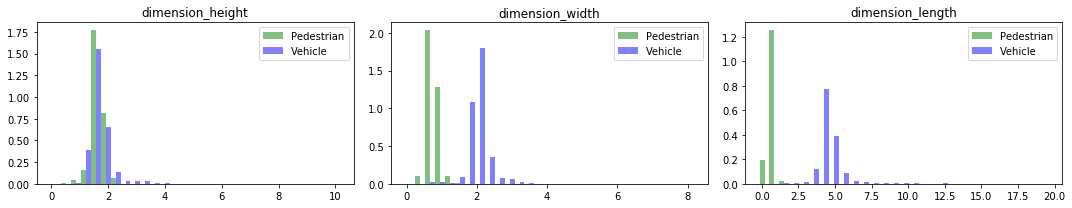

In [66]:
dimension_cols = ['dimension_height', 'dimension_width', 'dimension_length']
plot_subgroup_hist(objects_df[dimension_cols], pedestrians[dimension_cols], vehicles[dimension_cols]);

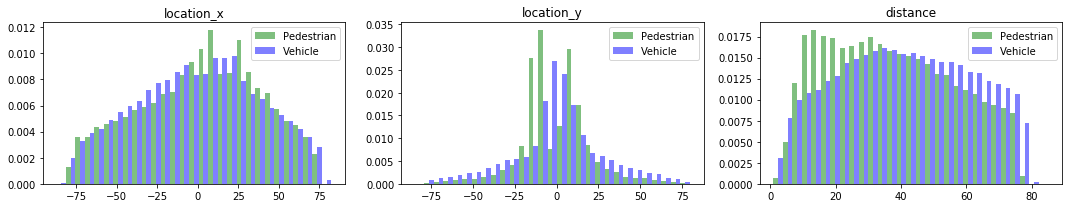

In [72]:
distance_cols = ['location_x', 'location_y', 'distance']
plot_subgroup_hist(objects_df[distance_cols], pedestrians[distance_cols], vehicles[distance_cols]);

In [203]:
heights, angles, bars = plt.hist(vehicles['heading'], bins=180);
plt.close()
angles_rad = np.radians(angles)[:180]

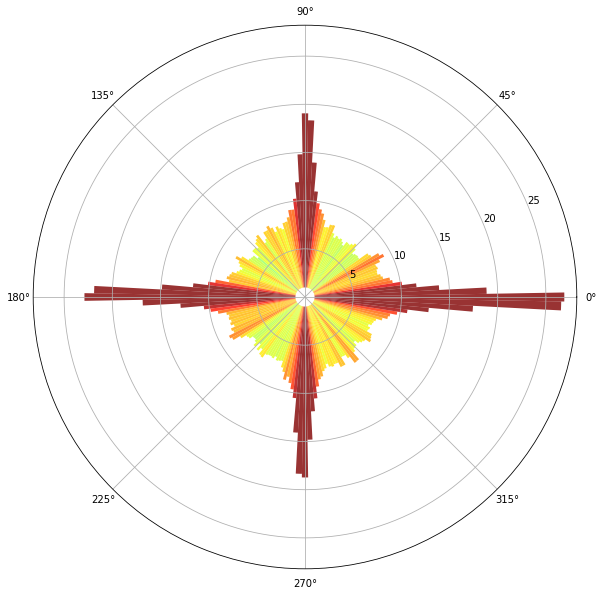

In [205]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))
N = 180
bottom = 1

theta = angles_rad
radii = (heights)**(1/np.pi)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

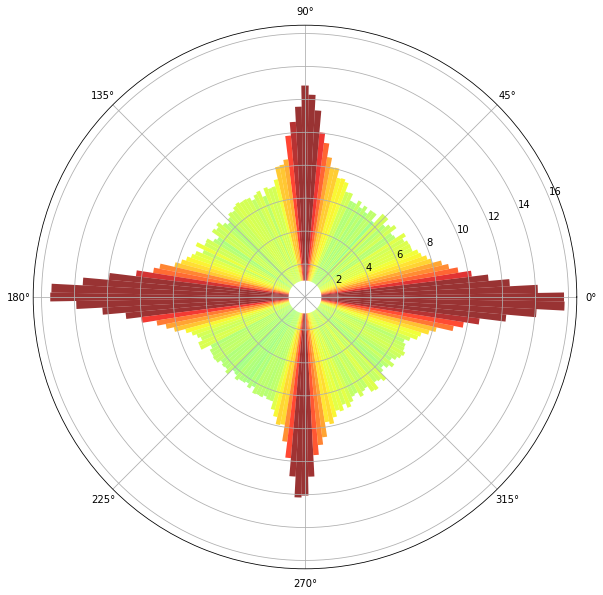

In [206]:
heights, angles, bars = plt.hist(ve['heading'], bins=180);
plt.close()
angles_rad = np.radians(angles)[:180]

fig, axs = plt.subplots(1,1, figsize=(10, 10))
N = 180
bottom = 1

theta = angles_rad
radii = (heights)**(1/np.pi)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

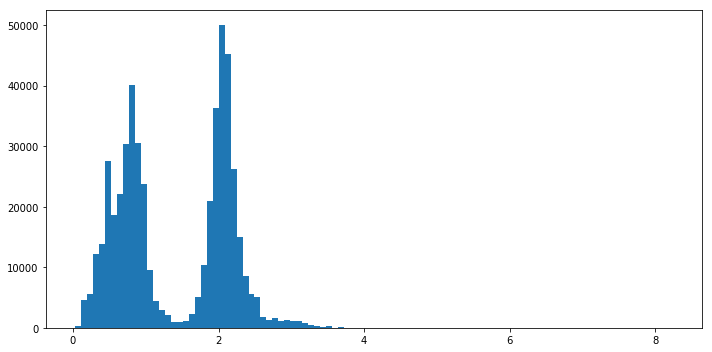

In [147]:
objects_df['dimension_width'].hist(bins=100,figsize=(10, 5), grid=False)
plt.tight_layout()

In [109]:
def plot_subgroup_hist(df, subs, labels):
    num_subs = len(subs)
    bp = []
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        
        for sub in subs:
            height, binz = np.histogram(sub[col_name], bins=bins, density=True)
            bp.append(ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.75, label=sub))
        
        ax.set_title(str(col_name).replace('_', ': ').title())
        label = tuple(i for i in labels)
        bp_leg = tuple(i[0] for i in bp)
        ax.legend(bp_leg, label, loc='best')

    plt.tight_layout()

    return fig, ax

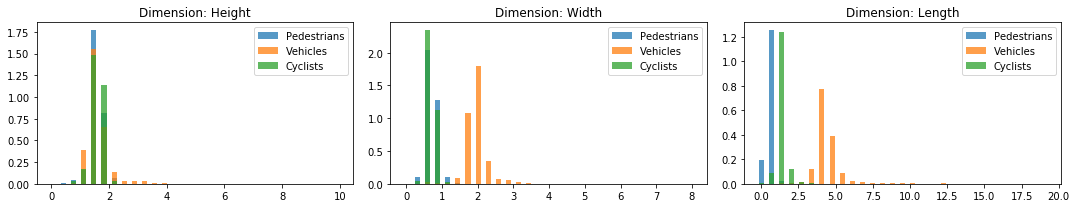

In [110]:
subs = [pedestrians[dimension_cols], vehicles[dimension_cols], cyclists[dimension_cols]]
labels = ["Pedestrians", "Vehicles", "Cyclists"]
plot_subgroup_hist(objects_df[dimension_cols], subs, labels);

0.15165182248485662 0.008695901291671235


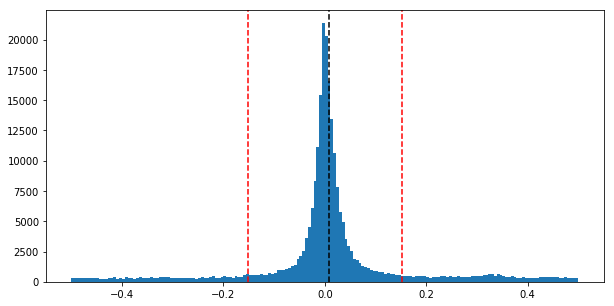

In [618]:
vehicles['dist'] = vehicles['heading']/90 - (vehicles['heading']/90).round(0)

fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.hist(vehicles['dist'], bins=180)
ax.axvline(np.std(vehicles['dist']), color='red', linestyle='--')
ax.axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax.axvline(np.mean(vehicles['dist']), color='black', linestyle='--')

print(np.std(vehicles['dist']), np.mean(vehicles['dist']))

In [619]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])

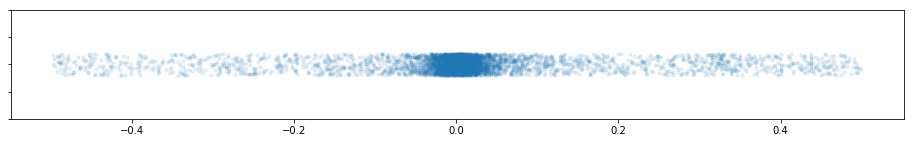

In [620]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(vehicles['dist'].sample(5000), ax, s=10, alpha=0.1)

In [621]:
heading_std_error = np.std(vehicles['dist']) / np.sqrt(vehicles['dist'].shape[0]) * 100
h0_dist = sts.norm(loc=0, scale=heading_std_error)

Text(0.5, 1.0, '$H_0$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car')

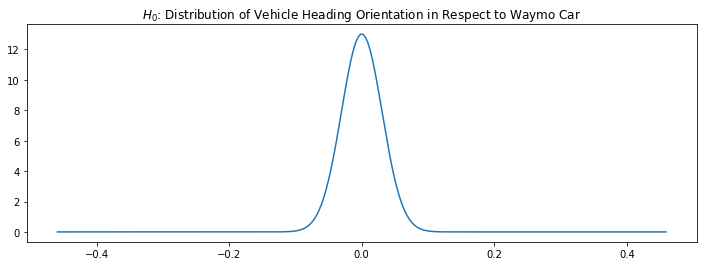

In [622]:
fig, ax = plt.subplots(figsize=(12, 4))

t = np.linspace(0 - 15*heading_std_error, 0 + 15*heading_std_error, num=250)
ax.plot(t, h0_dist.pdf(t))
ax.set_title("$H_0$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")

In [623]:
ha_dist = sts.norm(loc=0.06, scale=heading_std_error)

In [624]:
def plot_heading_distributions(ax):
    t = np.linspace(0.06 - 15*heading_std_error, 0.06 + 15*heading_std_error, num=250)
    ax.plot(t, h0_dist.pdf(t))
    ax.plot(t, ha_dist.pdf(t))
    #plt.xlim(-0.005,0.005)

Text(0.5, 1.0, '$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car')

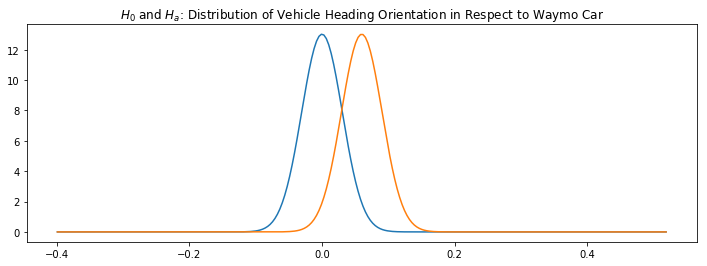

In [625]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_heading_distributions(ax)

ax.set_title("$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")

In [626]:
critical_value_right = h0_dist.ppf(1 - 0.1)
critical_value_left = h0_dist.ppf(0.1)

In [627]:
def plot_rejection_reigons(ax):
    t = np.linspace(0 - 10*heading_std_error, 0 + 10*heading_std_error, num=250)

    ax.axvline(critical_value_left, color="grey", linestyle="--")
    ax.axvline(critical_value_right, color="grey", linestyle="--")

    tpos = t[t >= critical_value_right]
    ax.fill_between(tpos, 0, h0_dist.pdf(tpos), alpha=0.2, label=r"$\alpha$")

    tneg = t[t <= critical_value_left]
    
    ax.axvline(np.mean(vehicles['dist']), color='black', linewidth=3)

    ax.fill_between(tneg, 0, h0_dist.pdf(tneg), alpha=0.2, label=r"$\alpha$")
    ax.set_title("$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")
    plt.show()

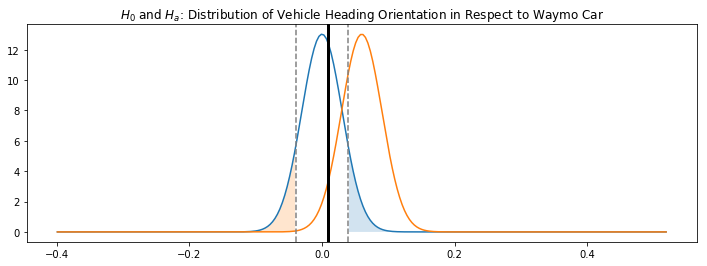

In [628]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_heading_distributions(ax)
plot_rejection_reigons(ax)

In [629]:
standard_critical_value = sts.norm().ppf(1 - 0.1)

left_endpoint = np.mean(vehicles['dist']) - standard_critical_value*heading_std_error
right_endpoint = np.mean(vehicles['dist']) + standard_critical_value*heading_std_error

print("95% Confidence Interval for Sample Mean: [{:2.5f}, {:2.5f}]".format(
    left_endpoint, right_endpoint))

print(left_endpoint*90, right_endpoint*90)

95% Confidence Interval for Sample Mean: [-0.03055, 0.04794]
-2.749607675843152 4.314869908343974


In [630]:
def plot_power_reigons(ax):
    t = np.linspace(np.mean(vehicles['dist']) - 10*heading_std_error, np.mean(vehicles['dist']) + 10*heading_std_error, num=250)

    ax.axvline(critical_value_left, color="grey", linestyle="--")
    ax.axvline(critical_value_right, color="grey", linestyle="--")

    tpos = t[t >= critical_value_right]
    ax.fill_between(tpos, 0, ha_dist.pdf(tpos), alpha=0.2, label=r"$\alpha$")

    tneg = t[t <= critical_value_left]
    ax.fill_between(tneg, 0, ha_dist.pdf(tneg), alpha=0.2, label=r"$\alpha$")

Text(0.5, 1.0, '$H_0$ and $H_a$ Distribution of Heading Orientation')

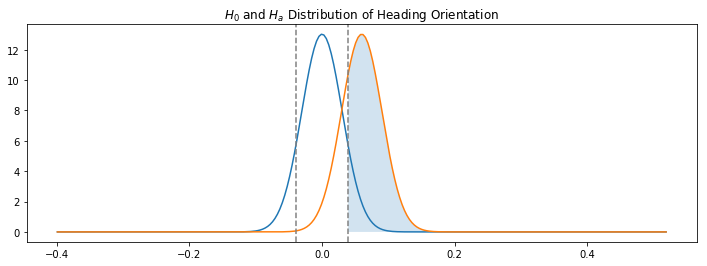

In [631]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_heading_distributions(ax)
plot_power_reigons(ax)

ax.set_title("$H_0$ and $H_a$ Distribution of Heading Orientation")

In [632]:
power = ha_dist.cdf(critical_value_left) + (1 - ha_dist.cdf(critical_value_right))

print("Power to Detect Effect: {:2.3f}".format(power))

Power to Detect Effect: 0.752


In [633]:
vehicle_heading = vehicles['heading']/90 - (vehicles['heading']/90).round(0)
pedestrian_heading = pedestrians['heading']/90 - (pedestrians['heading']/90).round(0)

In [537]:
stat, p_val = stats.ttest_ind(vehicle_heading, pedestrian_heading, equal_var=False)
print('The statistic is: {} \nP-value: {}'.format(stat ,p_val))

The statistic is: 2.4630471612283933 
P-value: 0.013777088066573


Text(0.5, 1.0, 'Distribution of Vehicle Heading')

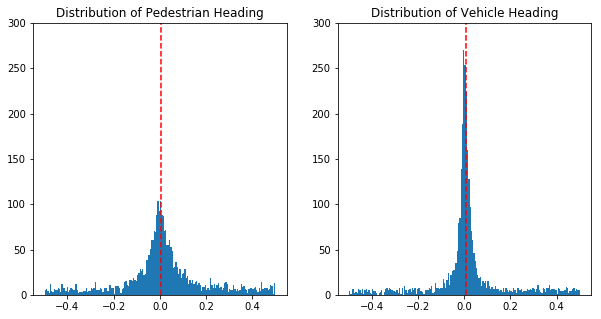

In [636]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(pedestrian_heading.sample(3000), bins=180);
#ax[0].axvline(np.std(pedestrian_heading), color='red', linestyle='--')
#ax[0].axvline(-np.std(pedestrian_heading), color='red', linestyle='--')
ax[0].axvline(np.mean(pedestrian_heading), color='red', linestyle='--')
ax[0].set_ylim(0,300)
ax[0].set_title('Distribution of Pedestrian Heading')

ax[1].hist(vehicle_heading.sample(3000), bins=180);
#ax[1].axvline(np.std(vehicles['dist']), color='red', linestyle='--')
#ax[1].axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax[1].axvline(np.mean(vehicles['dist']), color='red', linestyle='--')
ax[1].set_ylim(0,300)
ax[1].set_title('Distribution of Vehicle Heading')

Text(0.5, 1.0, 'Distribution of Vehicle Heading')

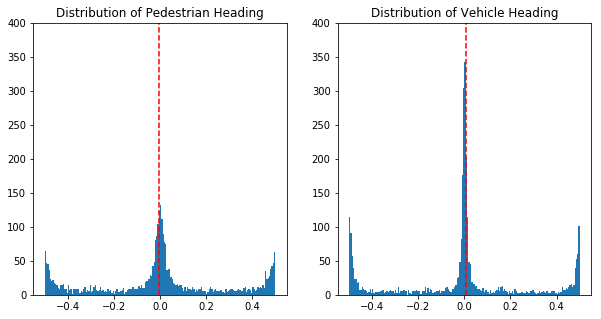

In [637]:
vehicle_heading = vehicles['heading']/180 - (vehicles['heading']/180).round(0)
pedestrian_heading = pedestrians['heading']/180 - (pedestrians['heading']/180).round(0)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(pedestrian_heading.sample(3000), bins=180);
#ax[0].axvline(np.std(pedestrian_heading), color='red', linestyle='--')
#ax[0].axvline(-np.std(pedestrian_heading), color='red', linestyle='--')
ax[0].axvline(np.mean(pedestrian_heading), color='red', linestyle='--')
ax[0].set_ylim(0,400)
ax[0].set_title('Distribution of Pedestrian Heading')

ax[1].hist(vehicle_heading.sample(3000), bins=180);
#ax[1].axvline(np.std(vehicles['dist']), color='red', linestyle='--')
#ax[1].axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax[1].axvline(np.mean(vehicles['dist']), color='red', linestyle='--')
ax[1].set_ylim(0,400)
ax[1].set_title('Distribution of Vehicle Heading')

In [607]:
stat, p_val = stats.ttest_ind(vehicle_heading, pedestrian_heading, equal_var=False)
print('The statistic is: {} \nP-value: {}'.format(stat ,p_val))

The statistic is: -4.7855148739785145 
P-value: 1.7066050980628102e-06
